# Прогнозирование вероятности оттока клиентов фитнес-центра

**Описание проекта**

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

**Задачи проекта:**

* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

 * выделить целевые группы клиентов; 
 * предложить меры по снижению оттока;
 * определить другие особенности взаимодействия с клиентами.
 
**Описание данных:**

**Данные клиента за предыдущий до проверки факта оттока месяц:**

* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**

* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.

## Загрузим и подготовим данные

Добавим необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

Загрузим и посмотрим данные.

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Изучим общую информацию.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

С типами данных всё в порядке. Приведем к нижнему регистру названия столбцов.

In [4]:
df.columns = df.columns.str.lower()

Проверим наличие пропусков.

In [5]:
df.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Пропуски не обнаружены. Проверим наличие дублиакатов.

In [6]:
df.duplicated().sum()

0

Дубликаты также не обнаружены.

**Вывод:** 
* Всего имеется 14 столбцов и 4000 строк с двумя типами данных `int64` и `float64`.
* Названия столбцов приведены к единому регистру - нижнему.
* С типами данных всё в порядке, вмешательство не требуется.
* Пропуски не обнаружены.
* Дубликаты не обнаружены.

## Исследовательский анализ данных (EDA)

**Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения**

Воспользуемся методом `describe()`, посмотрим на средние и стандартные значения.

In [7]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Как видно, стандартные отклонения не сильно отличаются от средних значений.

**Промежуточный вывод:**

* Распределение по полу примерно одинаково
* Большинство клиентов живет или работает рядом с фитнес-клубом - 85%
* Почти половина клиентов являются сотрудниками партнерских организаций
* По программе "Приведи друга" пришли 30% клиентов
* Известны контактные телефоны примерно 90% клиентов
* Средняя длительность абонементов клиентов - 4.6 месяцев
* Групповые занятия посещают около 40% клиентов  
* Средний возраст клиентов 29 лет
* Средние дополнительные расходы клиентов - 146.9
* Средний срок до окончания договора - 4.3 месяцев
* Среднее время с момента первого обращения в фитнес-центр - 3.7 месяцев
* Средняя частота посещений за все время - 1.87 раз в неделю
* Средняя частота посещений за последний месяц - 1.76 раз в неделю
* Доля оттока клиентов ~ 27%

**Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался**

In [8]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


**Вывод:**

* Распределение по полу примерно равное как для тех кто ушел, так и для тех, кто остался.
* Клиенты, живущие/работающие недалеко реже попадают в отток.
* Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб чем остальные клиенты.
* Клиенты, пришедшие по акции "Приведи друга" в два раза реже попадают в отток.
* Признак phone (контактный телефон) для обеих групп одинаков по 90%.
* Средняя длительность договора полне логично больше у оставшихся пользователей - 5-6 месяцев, у большей части клиентов в оттоке срок договора составляет 1-2 месяца.
* Заметно, что среди тех, кто ушел, только 26% посещали групповые занятие, а среди тех, кто остался, таких 46%.
* Средний возрастр клиентов оттока чуть меньше - 27 лет против 30 лет.
* Есть небольшое различие в выручке от других услуг фитнес-центра 115 у.е. - для ушедших, а среди оставшихся - 158 у.е.
* Лайфтайм для групп сильно отличается. Для ушедших он равен меньше 1 месяца, что свидетельствует от незаинтересованности последних.
* В среднем те, кто ушел, приходили на занятия:
   - за все время - на ~25% реже;
   - за предыдущий месяц - в два раза реже;

**Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)**

In [9]:
# поделим клиентов на две группы:
churn = df[df['churn']==1] # отток
not_churn = df[df['churn']==0] # оставшиеся

# и разделим признаки на две группы:

# числовые
numeric_feature = ['contract_period', 'age', 'avg_additional_charges_total', 
                    'month_to_end_contract','lifetime', 
                     'avg_class_frequency_total', 'avg_class_frequency_current_month']
# и булевы
boolean_feature = ['gender', 'near_location', 'partner',
                   'promo_friends', 'phone', 'group_visits'] 

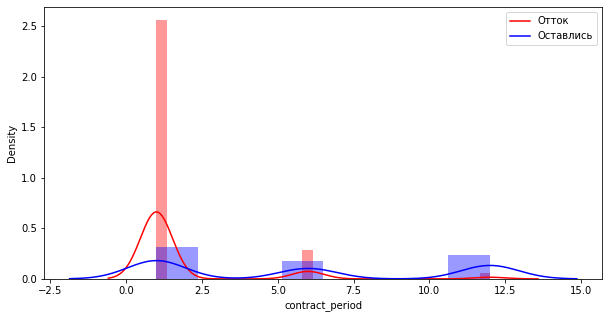

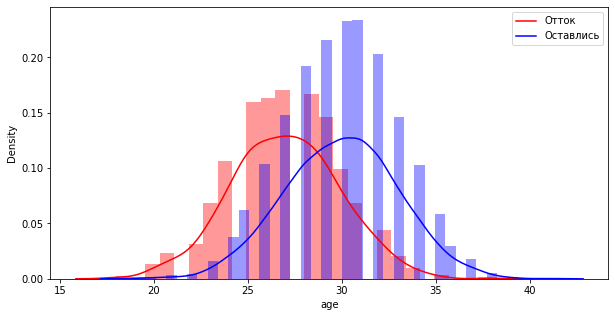

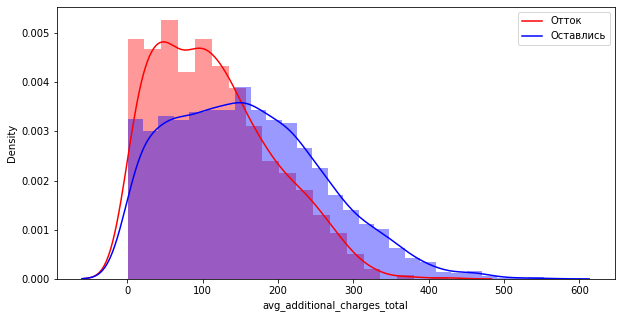

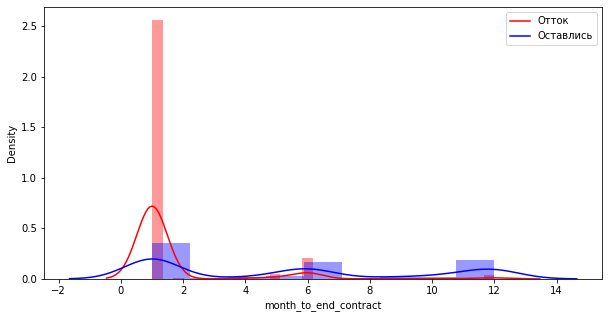

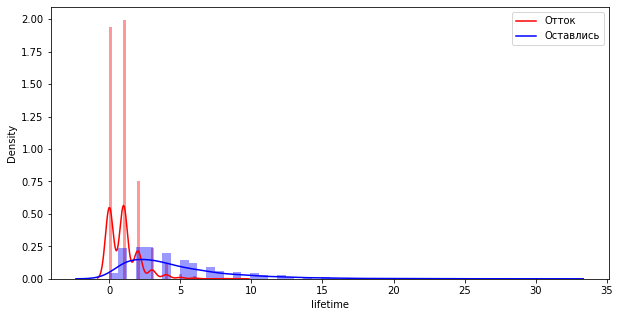

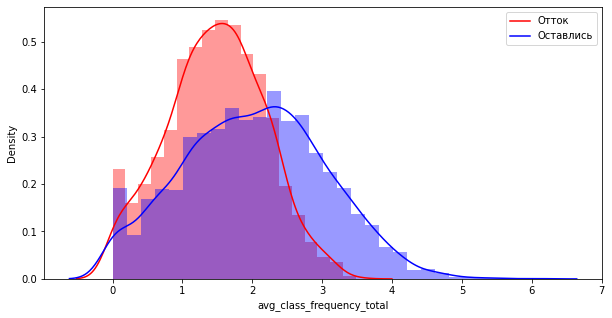

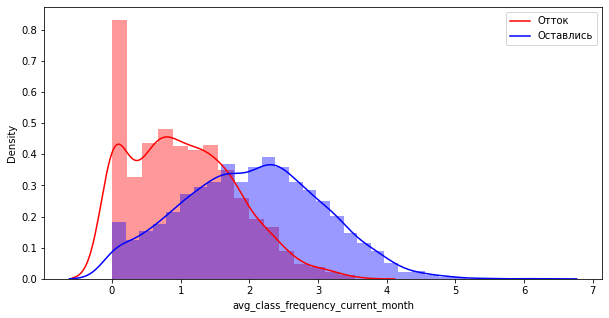

In [10]:
for column in numeric_feature: 
    plt.figure(figsize=(10,5))
    sns.distplot(churn[column], color = 'red')
    sns.distplot(not_churn[column], color = 'blue')
    plt.legend(['Отток', 'Оставлись'])
    plt.show()

**Вывод:**

* `contract_period` - чем дольше срок действия аббонемента, тем меньше отток

* `age` - клиенты возрастом возраста 25-27 лет больше склонны уйти, остаются клиенты более взрослого возраста 27-32 лет

* `avg_additional_charges_total` - доп. расходы для ушедших практически не превышали  300 у.е, доп. расходы для оставшихся - не более 400 у.е.

* `month_to_end_contract` - ситуация схожа с график срока действия аббонемента, практически у всех ушедших клиентов остается не более 1 месяца

* `lifetime` - видно, что уходят клиенты с "периодом жизни" до 3 месяцев

* `avg_class_frequency_total` - по графику видно, что при посещении зала 1 раз в неделю, доли ушедших и оставшихся примерно равны. Однако потом ситуация меняется при увеличении кол-ва походов в зал; так если клиент посещает спортзал 3 раза и более - вероятность его ухода практически равна нулю

* `avg_class_frequency_current_month` - ситуация схожа с предыдущим признаком, чем больше посещений в неделю за последний месяц, тем меньше отток

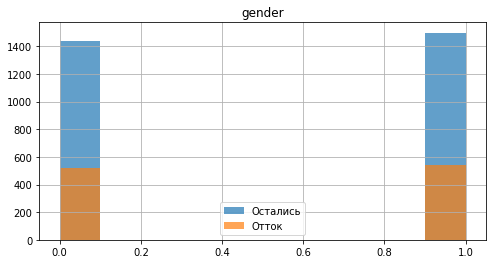

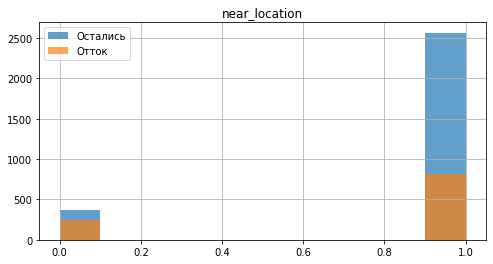

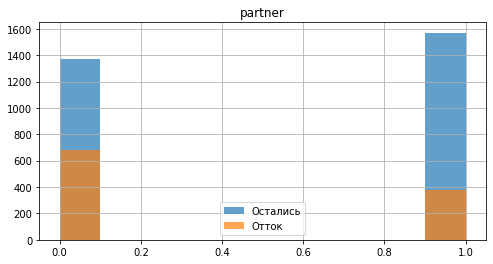

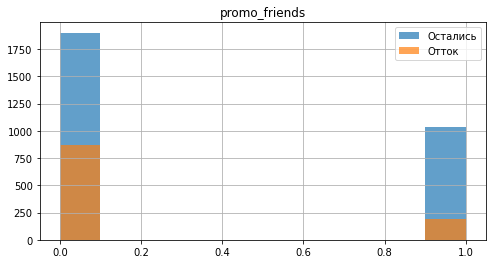

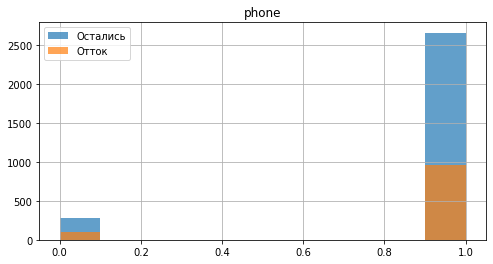

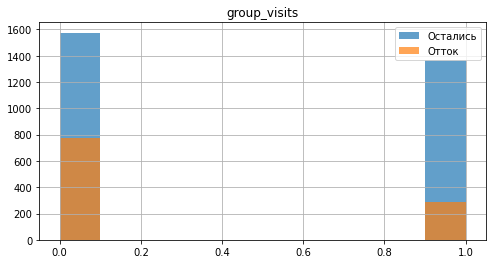

In [11]:
for column in df.columns:
    if column in boolean_feature:
        plt.figure(figsize=(8,4))
        df.groupby('churn')[column].hist(alpha = 0.7)
        plt.title(column)
        plt.legend(['Остались', 'Отток'])
        plt.show()

**Вывод:**

* `gender` - доли оттока примерно равны и для мужчин и для женщин

* `near_location` - живущих ближе значительно больше и среди них доля оставшихся тоже значительно больше

* `partner` - участвующих в партнерской программе примерно столько же скольтех кто не участвовал, также первые все же склонны продолжать ходить в зал

* `promo_friends` - доля клиентов по акции "приведи друга" меньше, однако  доля оставшихся среди них значительно больше

* `phone` - очевидно, что факт оставления клиентами номеров своих телефонов не влияет на факт "оттока"

* `group_visits` - посетители групповых занятий больше склонны продолжать тренировки

**Построим матрицу корреляций и отобразим её**

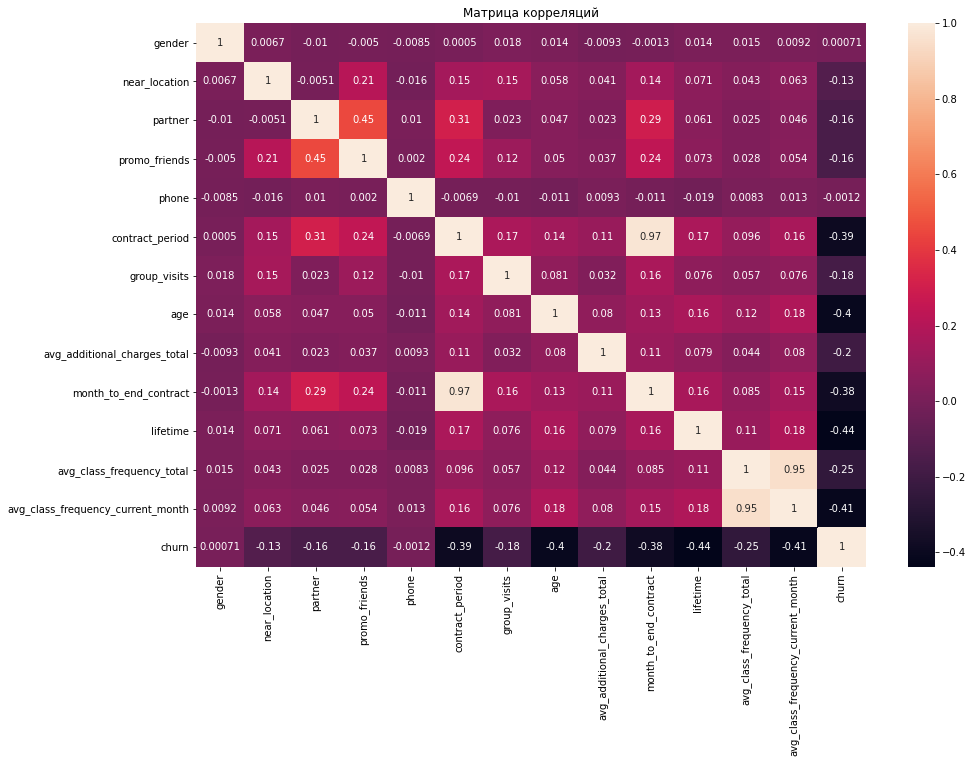

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(data = df.corr(), annot=True)
plt.title('Матрица корреляций')
plt.show()

**Вывод:**

Явной зависимости факта оттока `churn` от признаков не обнаружено. 

Наиболее сильно влияют три следующих признака (отрицательное значение, говорит об обратной зависимости - чем больше значение, тем меньше отток):

* `lifetime` - (-0.44)
* `avg_class_frequency_current_month` - (-0.41)
* `age` -  (-0.4)

Также следует отметить очень сильную корреляцию двух пар признаков:

* `contract_period` и `month_to_end_contract` (0.97) - чем больше период действия аббонемент, тем больше месяцев до окончания аббонемента
* `avg_class_frequency_current_month` и `avg_class_frequency_total` (0.95) - если количество походов в зал в за все время было постоянным, то скорее всего в прошлом месяце будет таким же



## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

**Разобъем данные на обучающую и валидационную выборку функцией train_test_split().**

In [13]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'])
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом.**

In [14]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()

 # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train) 

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [15]:
# зададим список моделей
models = [LogisticRegression(random_state=0), 
          RandomForestClassifier(random_state=0)]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )
    print()

**Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравним их по ним модели.**

In [16]:
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test
    )

LogisticRegression(random_state=0)
Accuracy: 0.920
Precision: 0.883
Recall: 0.808

RandomForestClassifier(random_state=0)
Accuracy: 0.909
Precision: 0.865
Recall: 0.780



**Вывод:** 
* по параметру `Accuracy` "Логистическая регрессия" немного выигрывает у "Случайный лес" (0.926 против 0.921)
* по параметру `Precision` также "Логистическая регрессия" получше (0.879 проитив 0.866) 
* по параметру `Recall` также "Логистическая регрессия" немного лучше (0.833 против 0.829)

Обе модели дают доволньно неплохие результаты, однако всё же немного лучше именно "Логистическая регрессия".

## Кластеризация клиентов

**Стандартизируем данные.**

In [17]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

**Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и отрисуем дендрограмму.**

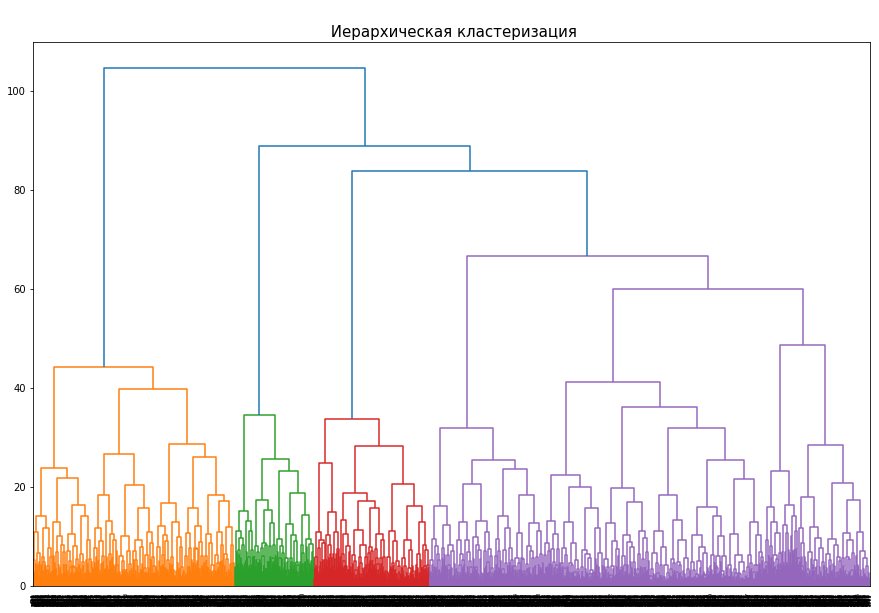

In [18]:
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('\n Иерархическая кластеризация', fontsize=15)
plt.show() 

**Предварительный вывод:**

На графике выделяются 4 кластера клиентов, судя по разным цветам нижних делений.

**Обучим модель кластеризации на основании алгоритма `K-Means` и спрогнозируем кластеры клиентов. По заданию за число кластеров `n` возьмем 5 кластеров.**

In [19]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

**Посмотрим на средние значения признаков для кластеров.**

In [20]:
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# выводим статистику по средним значениям признаков по кластеру
df.groupby('cluster_km').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


**Вывод:**

**Кластер 0:**

* Живут или работают недалеко от фитнес-центра
* Большинство являются сотрудниами компаний-партнеров - 78%
* Пришли по акции друзей - 57%
* Заключают договора на длительный срок - 11 месяцев
* Чаще всех посещают групповые занятия - 54%
* Самый долгий срок окончания абонемента - 10 месяцев
* **Самый низкий отток - 3 %** 

**Кластер 1:**

* Средний отток - 26%
* Живут или работают недалеко от фитнес-центра
* Единственный кластер, в котором клиенты не оставили номера телефонов
* Заключают договора на средний срок - 4-5 месяцев
* Чаще всех посещают клуб - 2.81 раз в неделю

**Кластер 2:**

* Живут или работают далеко от фитнес-центра
* Пришли не по приглашению друзей - 7%
* Заключают договора на малый срок - 2 месяца
* Реже всех посещают групповые занятия - 21%
* Высокий отток - 44% 

**Кластер 3:**

* Живут или работают недалеко от фитнес-центра
* Заключают договора на самый малый срок - 2 месяца
* Реже всех посещают групповые занятия
* Наименьший срок окончания абонемента - 2 месяцев
* Наименьшее кол-во посещений за всё время и в последний месяц - 1.24
* **Самый высокий отток - 51%**

**Кластер 4:**

* Живут или работают недалеко от фитнес-центра
* Заключают договора на малый срок - 2 месяца
* Самые большие траты на дополнительный услуги - 161 у.е.
* Наибольшее кол-во посещений за всё время и в последний месяц - 2.85
* Низкий отток - 6%

**Распределение признаков для кластеров.**

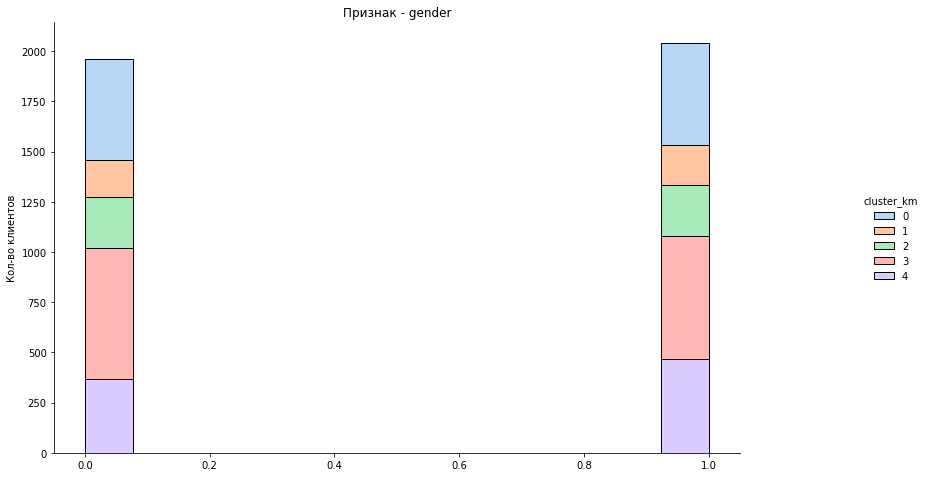

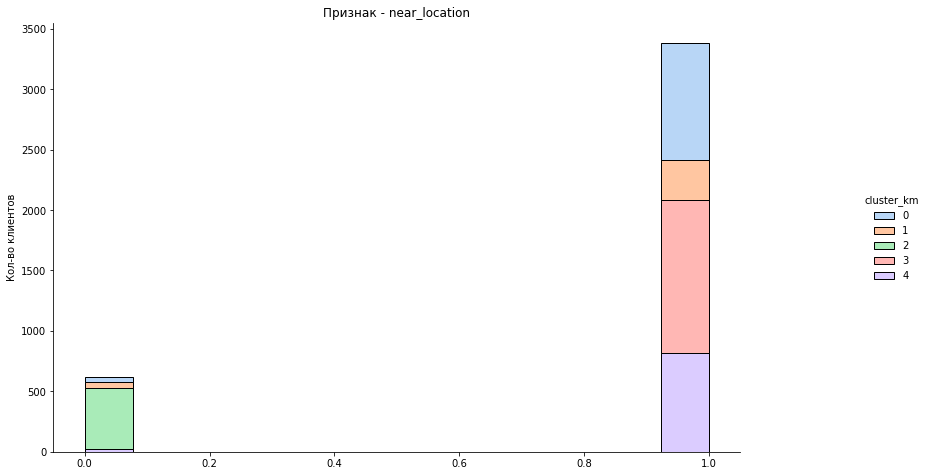

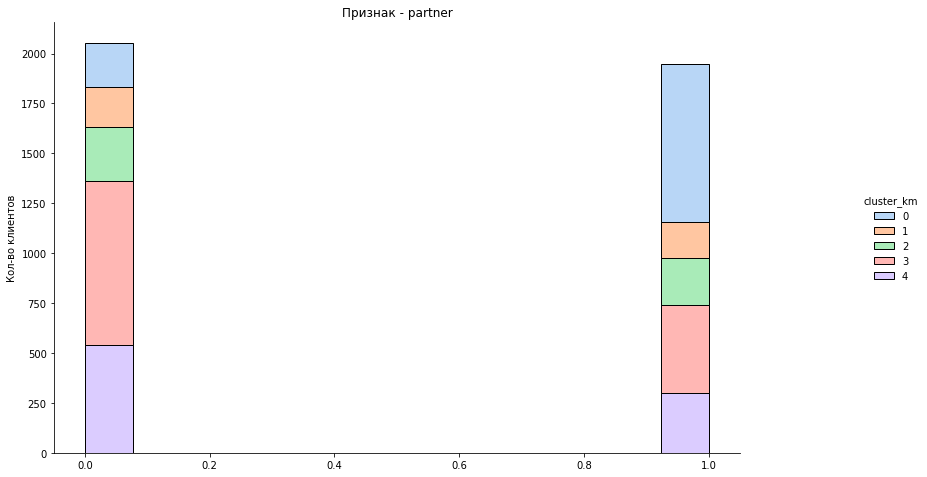

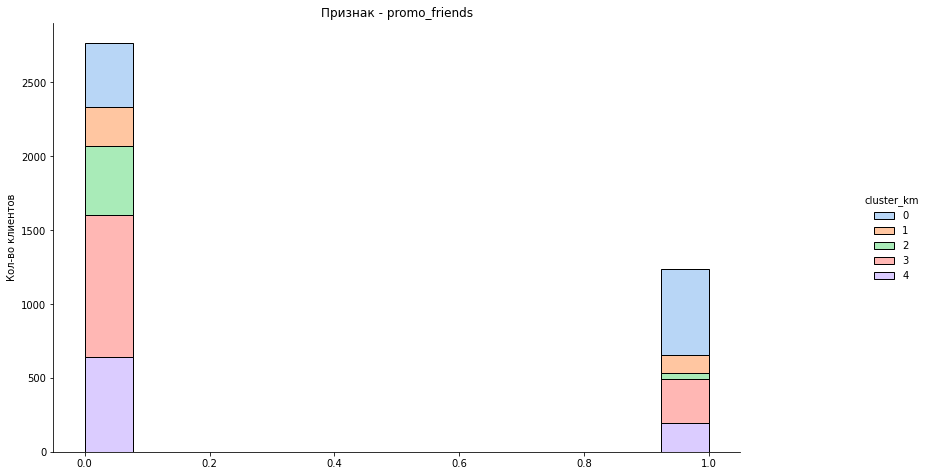

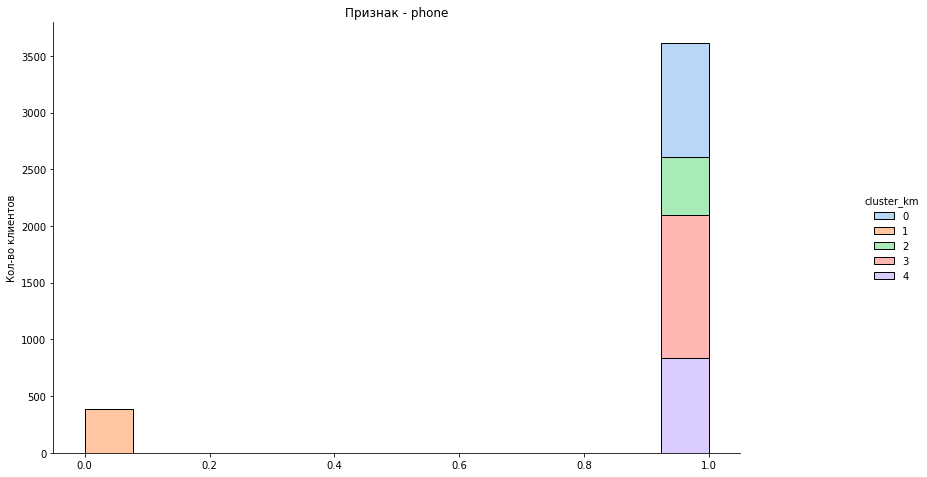

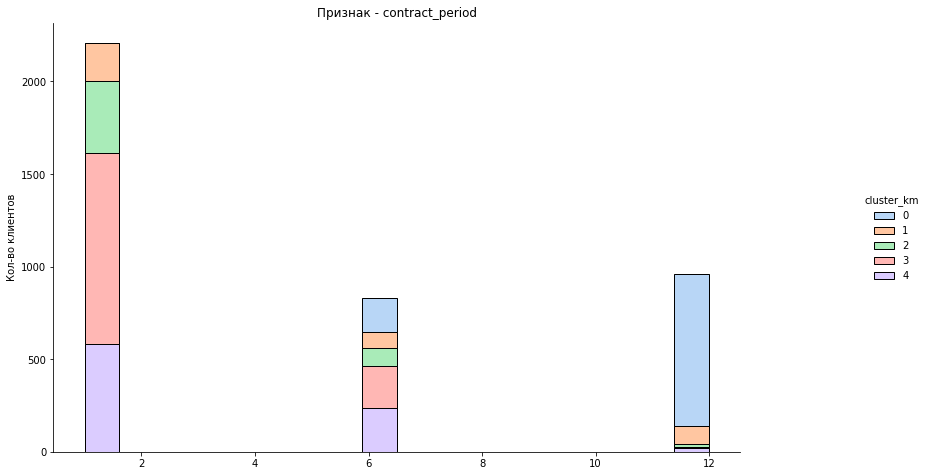

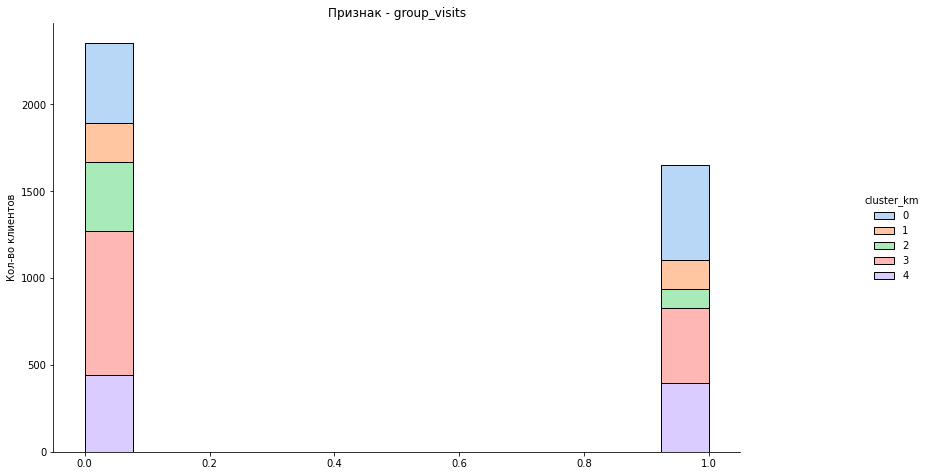

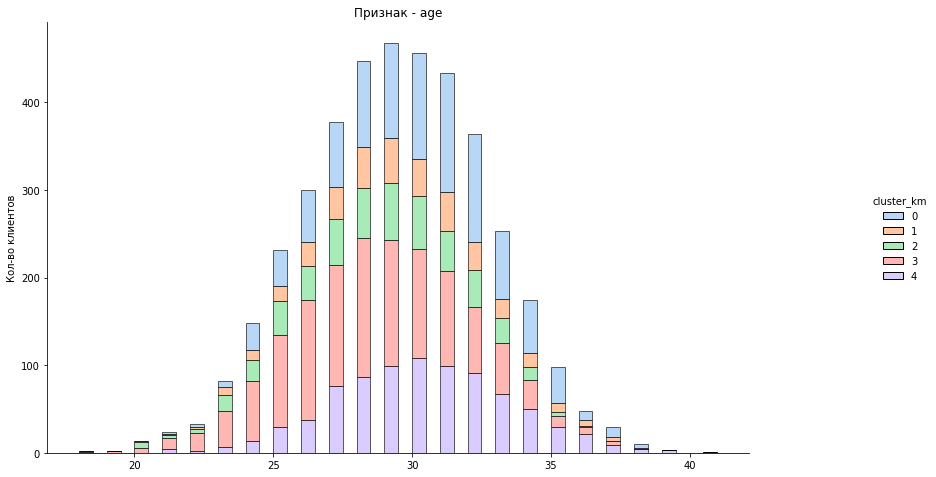

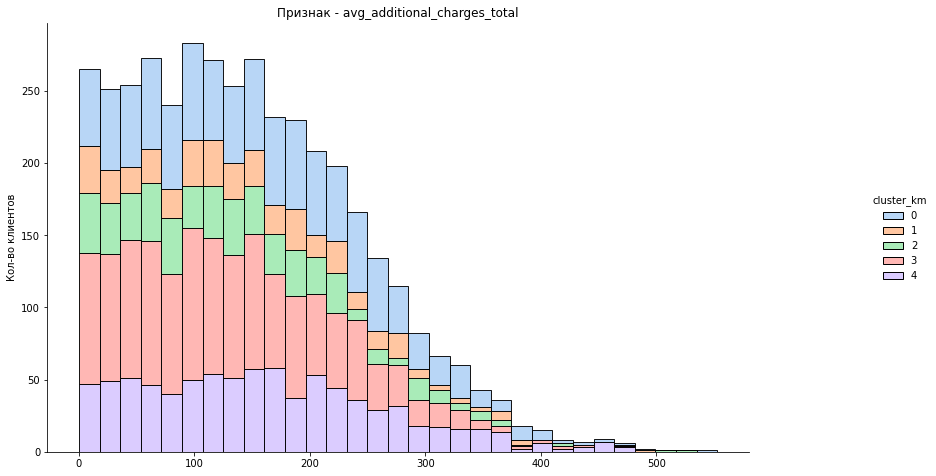

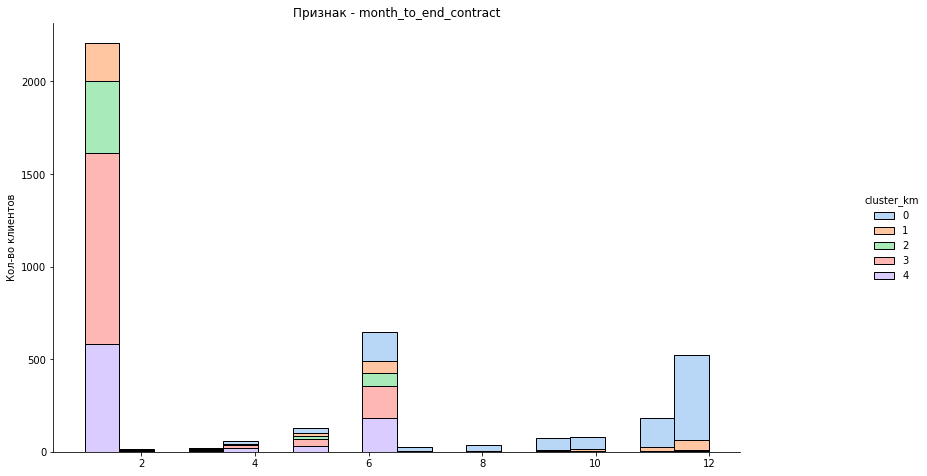

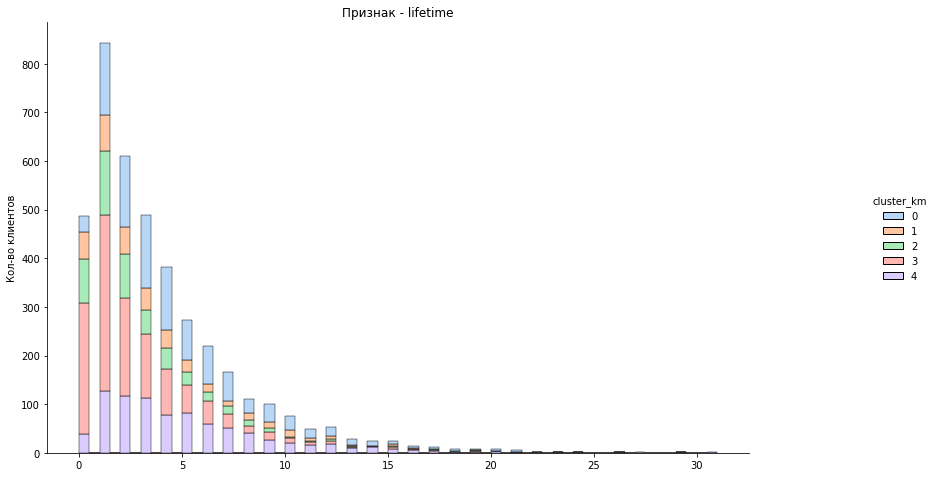

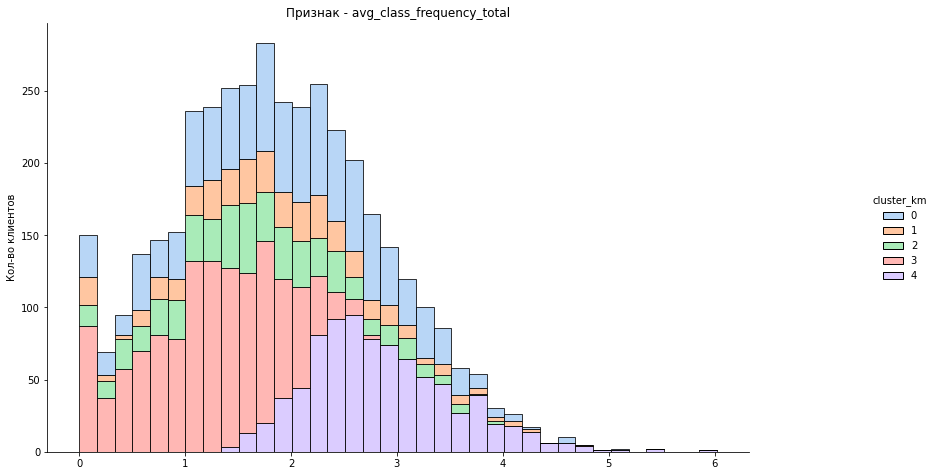

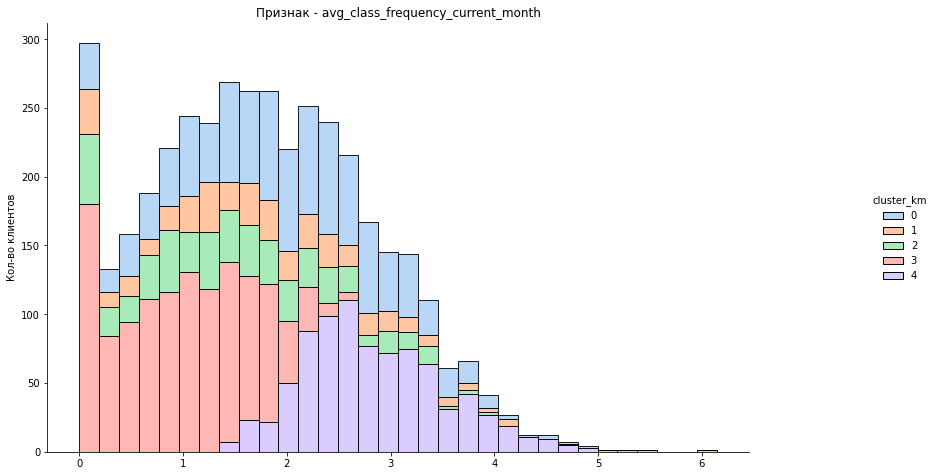

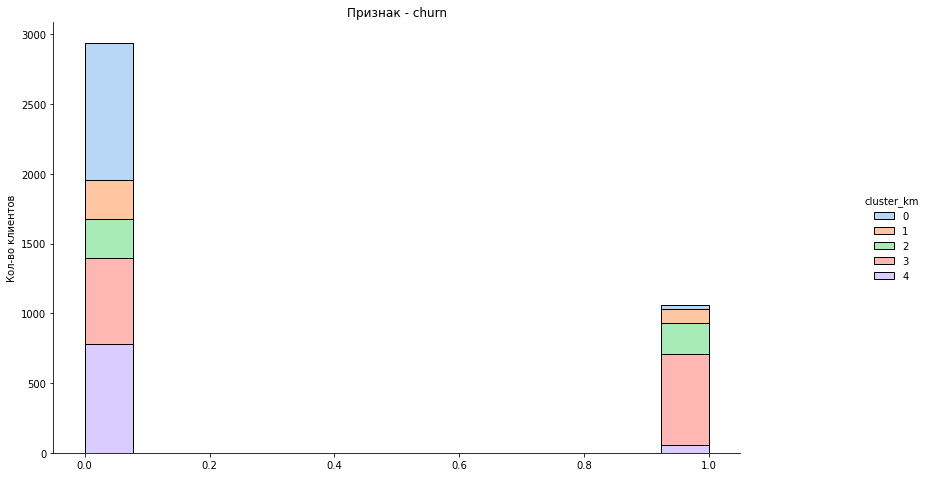

In [21]:
columns = df.drop(columns=['cluster_km'])
for f in columns:
    g = sns.displot(df, x=df[f], hue='cluster_km', multiple ='stack', palette='pastel') 

    plt.title(f'Признак - {f}')
    plt.ylabel('Кол-во клиентов')
    plt.xlabel('')
    g.fig.set_figwidth(14)
    g.fig.set_figheight(7)

**Вывод:**

* Распределение по полу во всех кластерах практически равное. В кластере 3 больше больше всего клиентов.
* Кластер 2 - единственный, в котором клиенты живущут далеко от фитнес-зала.
* В кластере 2 наибольшая часть клиентов (78%) - сотрудники компании-партнёра клуба. В остальных кластерах количество таких клиентов меньше половины.
* В кластере 0, клиенты, которые пришли в фитнес-зал по акции. В кластере 2 находятся клиенты, пришедшие в фитнес-зал сами.
* Клиенты всех кластеров, кроме 1, оставили номер телефона.
* В 4 кластере - клиенты с максимально долгим абонементом. В 3 кластере - наоборот наименьший срок действия абонемента (меньше  2 месяцев).
* Клиенты кластера 3 меньше всего посещают групповые занятия (21%). В остальных кластерах клиенты разделены примерно поровну.
* Средний возраст клиентов всех кластеров распределен равномерно,в районе 28-30 лет.
* Чуть больше трат замечено в кластерах 0 и 4 (160 у.е.), в остальных траты в районе (131 -143 у.е.).
* Больше всего времени до окончания абонемента осталось у клиентов кластера 0 (10 месяцев), меньше всего времени есть у кластеров 2,3,и 4 (около 2 месяцев).
* Среднее время с момента первого обращения в фитнес-зал у кластера 0 (4.7 месяца), у клиентов из кластера 3 это значение наименьшее (2.4 месяца).
* За прошедших месяц чаще всего ходят в зал клиенты из кластера 4 (2.8 раз в неделю), меньше всего из кластера 3 (1.24 раз в неделю). 
* За всё время картина частоты похода в зал практически идентична предыдущему графику.
* В 0 и 4 кластерах собраны клиенты с меньшим оттоком (2% и 6%), в 3 и 4 кластерах средний отток больше (44% и 51%).

**Для каждого полученного кластера посчитаем долю оттока методом groupby().**

In [22]:
churn_share = df.groupby('cluster_km')['churn'].agg('sum') / df.groupby('cluster_km')['churn'].count()
churn_share

cluster_km
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64

Кластеры 1 и 3 склонны к оттоку (41 - 51% клентов ушло), кластеры 0 и 4 более надёжны (ушло только 2 - 6% клиентов).

## Общие выводы и рекомендации

Была проведена большая работа по прогнозированию оттока клиентов сети фитнес-центров «Культурист-датасаентист». На основе чего можно сделать следующие выводы.

1\. **Подготовка данных:**

* Всего имеется 14 столбцов и 4000 строк с двумя типами данных `int64` и `float64`.
* Названия столбцов приведены к единому регистру - нижнему.
* С типами данных всё в порядке, вмешательство не требуется.
* Пропуски не обнаружены.
* Дубликаты не обнаружены.

2\. **Исследовательский анализ данных EDA:**

* Распределение по полу примерно равное как для тех кто ушел, так и для тех, кто остался.
* Клиенты, живущие/работающие недалеко реже попадают в отток.
* Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб чем остальные клиенты.
* Клиенты, пришедшие по акции "Приведи друга" в два раза реже попадают в отток.
* Признак phone (контактный телефон) для обеих групп одинаков по 90%.
* Средняя длительность договора полне логично больше у оставшихся пользователей - 5-6 месяцев, у большей части клиентов в оттоке срок договора составляет 1-2 месяца.
* Заметно, что среди тех, кто ушел, только 26% посещали групповые занятие, а среди тех, кто остался, таких 46%.
* Средний возрастр клиентов оттока чуть меньше - 27 лет против 30 лет.
* Есть небольшое различие в выручке от других услуг фитнес-центра 115 у.е. - для ушедших, а среди оставшихся - 158 у.е.
* Лайфтайм для групп сильно отличается. Для ушедших он равен меньше 1 месяца, что свидетельствует от незаинтересованности последних.
* В среднем те, кто ушел, приходили на занятия:
   - за все время - на ~25% реже;
   - за предыдущий месяц - в два раза реже;
 
3\. **Кластеризация:**

**Кластер 0:**

* Живут или работают недалеко от фитнес-центра
* Большинство являются сотрудниами компаний-партнеров - 78%
* Пришли по акции друзей - 57%
* Заключают договора на длительный срок - 11 месяцев
* Чаще всех посещают групповые занятия - 54%
* Самый долгий срок окончания абонемента - 10 месяцев
* **Самый низкий отток - 3 %** 

**Кластер 1:**

* Средний отток - 26%
* Живут или работают недалеко от фитнес-центра
* Единственный кластер, в котором клиенты не оставили номера телефонов
* Заключают договора на средний срок - 4-5 месяцев
* Чаще всех посещают клуб - 2.81 раз в неделю

**Кластер 2:**

* Живут или работают далеко от фитнес-центра
* Пришли не по приглашению друзей - 7%
* Заключают договора на малый срок - 2 месяца
* Реже всех посещают групповые занятия - 21%
* Высокий отток - 44% 

**Кластер 3:**

* Живут или работают недалеко от фитнес-центра
* Заключают договора на самый малый срок - 2 месяца
* Реже всех посещают групповые занятия
* Наименьший срок окончания абонемента - 2 месяцев
* Наименьшее кол-во посещений за всё время и в последний месяц - 1.24
* **Самый высокий отток - 51%**

**Кластер 4:**

* Живут или работают недалеко от фитнес-центра
* Заключают договора на малый срок - 2 месяца
* Самые большие траты на дополнительный услуги - 161 у.е.
* Наибольшее кол-во посещений за всё время и в последний месяц - 2.85
* Низкий отток - 6%

**Рекомендации по работе с клиентами:**
1. Внедрение индивидуального подхода к клиентам. Проявление заинтересованности в их целях, предложение советов и помощи в достижении желаемого результата.
2. Организация приятной атмосферы в зале, поддержание чистоты и исправности тренажеров для стимулирования клиентов к более частым походам на тренировки.
3. Развитие социального взаимодействия через популярные интернет-ресурсы. Там же афишировать партнерские программы и промо-акции.